In [1]:
import numpy as np
import pandas as pd
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Homework_Files/diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
df['admission_type_id'].replace([1,2,3,4,5,6,7,8],
                                   ['Emergency','Urgent','Elective','Newborn', np.nan, np.nan,'Trauma_Center', np.nan],inplace=True)

df['admission_type_id'].value_counts()

Emergency        53990
Elective         18869
Urgent           18480
Trauma_Center       21
Newborn             10
Name: admission_type_id, dtype: int64

In [5]:
df['discharge_disposition_id'].replace(np.arange(1,31),  ['ToHome' , 'ToShortTermHosp','ToSNF','ToICF','ToInpatientCareInst','ToHomeWithHomeHealthCare',
                                   'LeftAMA','ToHomeIVProvider','InpatientInSameHosp','AnotherHospNeonatalCare','Expired',
                                   'StillPatientOROutpatient','Hospice/Home','Hospice/Med.Facility','MedicareApprovedSwingBed',
                                   'AnotherInst.Outpatient','SameInst.Outpatient', np.nan,'ExpiredAtHome.MedicaidOnly',
                                  'ExpiredInMedFacility.MedicaidOnly','ExpiredUnknown.MedicaidOnly','ToRehab','ToLongTermCare',
                                   'ToNursingFac(MedicaidCertified,MedicareNotCertified)', np.nan, np.nan,
                                   'ToFederalHealthCareFac.','ToPsychiatricHosp.','ToCAHosp','ToUnknownHCHosp.']
                                   ,inplace=True)
df['discharge_disposition_id'].value_counts()

ToHome                                                  60234
ToSNF                                                   13954
ToHomeWithHomeHealthCare                                12902
ToShortTermHosp                                          2128
ToRehab                                                  1993
Expired                                                  1642
ToInpatientCareInst                                      1184
ToICF                                                     815
LeftAMA                                                   623
ToLongTermCare                                            412
Hospice/Home                                              399
Hospice/Med.Facility                                      372
ToPsychiatricHosp.                                        139
ToHomeIVProvider                                          108
MedicareApprovedSwingBed                                   63
ToNursingFac(MedicaidCertified,MedicareNotCertified)       48
Inpatien

In [6]:
df['admission_source_id'].replace(np.arange(1, 27), [
    'PhysicianReferral', 'ClinicReferral', 'HMOReferral',
    'Transferfromahospital', ' TransferfromaSkilledNursingFacility(SNF)',
    'Transferfromanotherhealthcarefacility', 'EmergencyRoom',
    'Court/LawEnforcement', np.nan,
    'Transferfromcritialaccesshospital', 'NormalDelivery', 'PrematureDelivery',
    'SickBaby', 'ExtramuralBirth', np.nan, '', np.nan,
    'TransferFromAnotherHomeHealthAgency', 'ReadmissiontoSameHomeHealthAgency',
    np.nan, np.nan,
    'Transferfromhospitalinpt/samefacresultinasepclaim',
    'Borninsidethis hospital', ' Bornoutsidethishospital',
    'TransferfromAmbulatorySurgeryCenter', 'TransferfromHospice'
],
                                     inplace=True)

df['admission_source_id'].value_counts()

EmergencyRoom                                        57494
PhysicianReferral                                    29565
Transferfromahospital                                 3187
Transferfromanotherhealthcarefacility                 2264
ClinicReferral                                        1104
 TransferfromaSkilledNursingFacility(SNF)              855
HMOReferral                                            187
Court/LawEnforcement                                    16
Transferfromhospitalinpt/samefacresultinasepclaim       12
Transferfromcritialaccesshospital                        8
ExtramuralBirth                                          2
NormalDelivery                                           2
TransferfromAmbulatorySurgeryCenter                      2
SickBaby                                                 1
Name: admission_source_id, dtype: int64

In [7]:
cols = ['diag_1','diag_2','diag_3']
df[cols] = df[cols].apply(pd.to_numeric,errors='coerce')

In [8]:
df = df.replace('?', np.nan)
df = df.replace('None', np.nan)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,1.652016e+08,1.026403e+08,12522.0,84961194.0,152388987.0,2.302709e+08,443867222.0
patient_nbr,101766.0,5.433040e+07,3.869636e+07,135.0,23413221.0,45505143.0,8.754595e+07,189502619.0
time_in_hospital,101766.0,4.395987e+00,2.985108e+00,1.0,2.0,4.0,6.000000e+00,14.0
num_lab_procedures,101766.0,4.309564e+01,1.967436e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,101766.0,1.339730e+00,1.705807e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,101766.0,1.602184e+01,8.127566e+00,1.0,10.0,15.0,2.000000e+01,81.0
number_outpatient,101766.0,3.693572e-01,1.267265e+00,0.0,0.0,0.0,0.000000e+00,42.0
number_emergency,101766.0,1.978362e-01,9.304723e-01,0.0,0.0,0.0,0.000000e+00,76.0
number_inpatient,101766.0,6.355659e-01,1.262863e+00,0.0,0.0,0.0,1.000000e+00,21.0
diag_1,100100.0,4.935831e+02,2.067153e+02,3.0,410.0,440.0,5.990000e+02,999.0


In [10]:
df.describe(include="object").T

,count,unique,top,freq
race,99493,5,Caucasian,76099
gender,101766,3,Female,54708
age,101766,10,[70-80),26068
weight,3197,9,[75-100),1336
admission_type_id,91370,5,Emergency,53990
discharge_disposition_id,97086,24,ToHome,60234
admission_source_id,94699,14,EmergencyRoom,57494
payer_code,61510,17,MC,32439
medical_specialty,51817,72,InternalMedicine,14635
max_glu_serum,5346,3,Norm,2597


In [11]:
dtypes=pd.DataFrame(df.dtypes,columns=["Data Type"])
dtypes["Unique Values"]=df.nunique()
dtypes["Null Values"]=df.isnull().sum()
dtypes["% null Values"]=df.isnull().sum()/len(df)
dtypes.style.background_gradient(cmap='Set2',axis=0)

,Data Type,Unique Values,Null Values,% null Values
encounter_id,int64,101766,0,0.000000
patient_nbr,int64,71518,0,0.000000
race,object,5,2273,0.022336
gender,object,3,0,0.000000
age,object,10,0,0.000000
weight,object,9,98569,0.968585
admission_type_id,object,5,10396,0.102156
discharge_disposition_id,object,24,4680,0.045988
admission_source_id,object,14,7067,0.069444
time_in_hospital,int64,14,0,0.000000


In [12]:
df = df.drop(['weight', 'payer_code', 'medical_specialty',
              'max_glu_serum', 'A1Cresult', 'examide', 'citoglipton'], axis=1)
df.shape

(101766, 43)

In [13]:
df['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [14]:
df['gender'] = df['gender'].replace('Unknown/Invalid', np.nan)

In [15]:
mode_cols = ['gender', 'race', 'admission_type_id',
             'discharge_disposition_id', 'admission_source_id',]

for col in mode_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)
    print(f'{col} # of Nulls: ', df[col].isna().sum())

gender # of Nulls:  0
race # of Nulls:  0
admission_type_id # of Nulls:  0
discharge_disposition_id # of Nulls:  0
admission_source_id # of Nulls:  0


In [16]:
mean_cols = ['diag_1','diag_2','diag_3']
for col in mean_cols:
    df[col].fillna(df[col].mean(), inplace=True)
    print(f'{col} # of Nulls: ', df[col].isna().sum())

diag_1 # of Nulls:  0
diag_2 # of Nulls:  0
diag_3 # of Nulls:  0


In [17]:
dtypes=pd.DataFrame(df.dtypes,columns=["Data Type"])
dtypes["Unique Values"]=df.nunique()
dtypes["Null Values"]=df.isnull().sum()
dtypes["% null Values"]=df.isnull().sum()/len(df)
dtypes.style.background_gradient(cmap='Set2',axis=0)

,Data Type,Unique Values,Null Values,% null Values
encounter_id,int64,101766,0,0.000000
patient_nbr,int64,71518,0,0.000000
race,object,5,0,0.000000
gender,object,2,0,0.000000
age,object,10,0,0.000000
admission_type_id,object,5,0,0.000000
discharge_disposition_id,object,24,0,0.000000
admission_source_id,object,14,0,0.000000
time_in_hospital,int64,14,0,0.000000
num_lab_procedures,int64,118,0,0.000000


In [18]:
X = df.drop(['encounter_id', 'patient_nbr'], axis=1)

In [19]:
ordi_cols = [
    'gender', 'acetohexamide', 'tolbutamide', 'troglitazone',
    'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
    'diabetesMed', 'readmitted', 'race', 'age', 'admission_type_id',
    'discharge_disposition_id', 'admission_source_id', 'metformin',
    'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide',
    'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
    'tolazamide', 'insulin', 'glyburide-metformin'
]

num_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses'
]

all_cols = ordi_cols + num_cols

In [20]:
num_pipe = imbPipeline([
    ('ss', StandardScaler())
])

ordi_pipe = imbPipeline([('ord', OrdinalEncoder())])

transformer = ColumnTransformer([
    ('ordi', ordi_pipe, ordi_cols),
    ('integer', num_pipe, num_cols),
])

X_transformed = pd.DataFrame(transformer.fit_transform(X))
X_transformed

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.106517,-0.785398,-1.848268,-0.291461,-0.21262,-0.503276,-1.184073,0.000000,-6.625735e-16,-3.321596
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.808384,-0.785398,0.243390,-0.291461,-0.21262,-0.503276,-1.061302,-1.069901,-9.510184e-01,0.815784
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.631351,2.145781,-0.371804,1.286748,-0.21262,0.288579,0.753197,-1.069958,-6.625735e-16,-0.735733
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.045967,-0.199162,-0.002688,-0.291461,-0.21262,-0.503276,-2.368522,-1.067519,-8.846576e-02,-0.218561
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.401761,-0.785398,-0.986997,-0.291461,-0.21262,-0.503276,-1.446639,-1.597352,-9.801587e-01,-1.252906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.401761,-0.785398,-0.002688,-0.291461,-0.21262,-0.503276,-1.187488,-0.837451,2.320775e-01,0.815784
101762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.513139,0.973309,0.243390,-0.291461,-0.21262,0.288579,0.323961,-0.922514,2.149509e+00,0.815784
101763,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.503417,-0.785398,-0.863958,0.497643,-0.21262,-0.503276,-2.222191,0.858151,-7.120680e-01,2.884475
101764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.096794,0.387074,0.612506,-0.291461,-0.21262,0.288579,2.450632,-0.871476,3.379229e+00,0.815784


In [21]:
X_transformed.shape

(101766, 41)

100%|██████████| 19/19 [00:42<00:00,  2.23s/it]


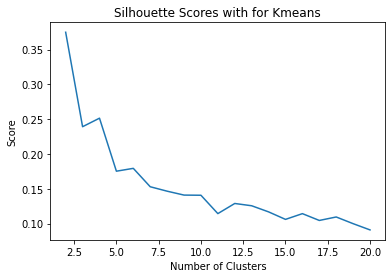

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

sample = X_transformed.sample(frac=0.1, random_state=42)

n_clusters=list(range(2,21))
scores = []

for n in tqdm(n_clusters):
    km = KMeans(n_clusters=n)
    km.fit_predict(sample)
    score = silhouette_score(sample, km.labels_, metric='euclidean')
    scores.append(score)
    
plt.title(f'Silhouette Scores with for Kmeans')
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.plot(n_clusters, scores)
plt.show()

100%|██████████| 19/19 [00:37<00:00,  1.95s/it]


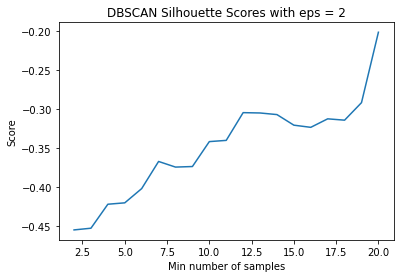

100%|██████████| 19/19 [00:34<00:00,  1.79s/it]


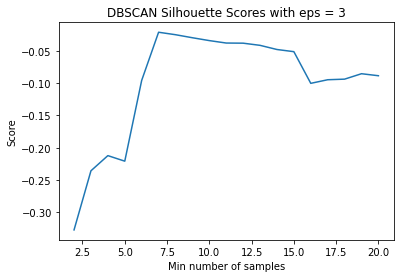

100%|██████████| 19/19 [00:38<00:00,  2.03s/it]


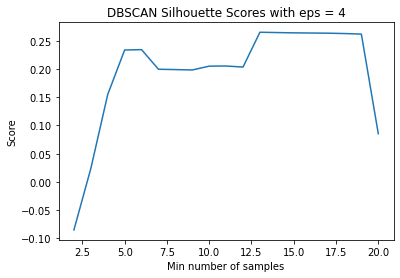

100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


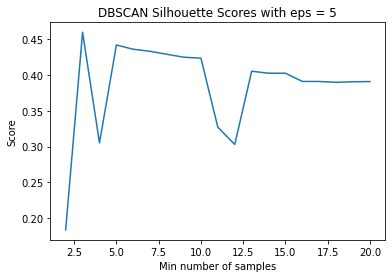

100%|██████████| 19/19 [00:45<00:00,  2.40s/it]


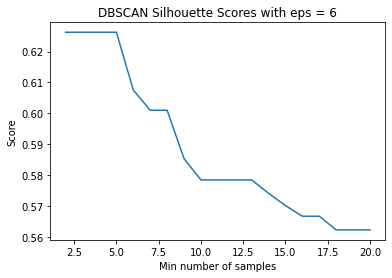

100%|██████████| 19/19 [00:47<00:00,  2.53s/it]


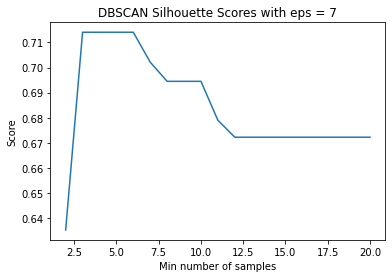

100%|██████████| 19/19 [00:47<00:00,  2.49s/it]


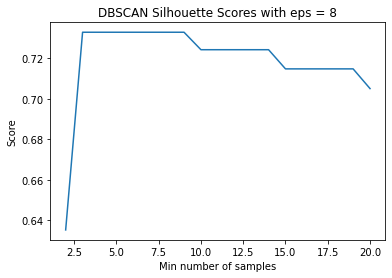

100%|██████████| 19/19 [00:46<00:00,  2.47s/it]


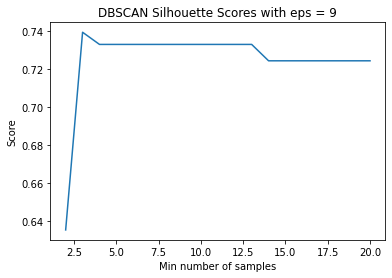

100%|██████████| 19/19 [00:46<00:00,  2.44s/it]


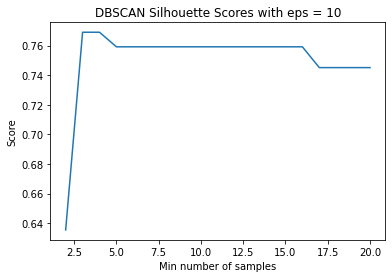

100%|██████████| 19/19 [00:45<00:00,  2.42s/it]


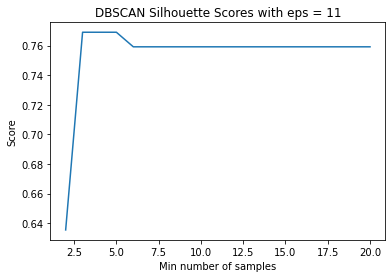

100%|██████████| 19/19 [00:46<00:00,  2.46s/it]


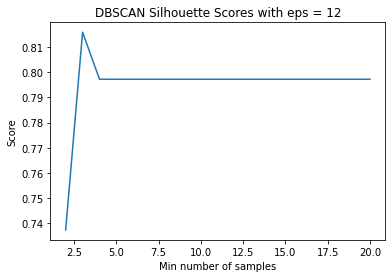

100%|██████████| 19/19 [00:45<00:00,  2.42s/it]


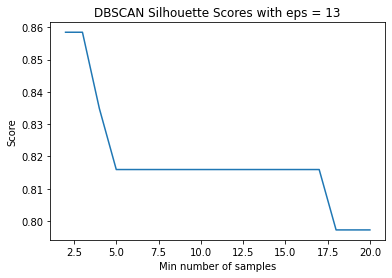

100%|██████████| 19/19 [00:46<00:00,  2.43s/it]


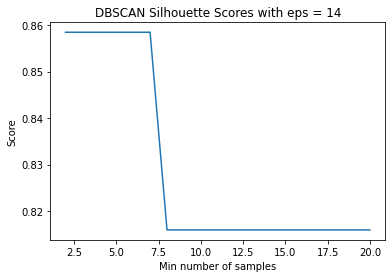

100%|██████████| 19/19 [00:46<00:00,  2.46s/it]


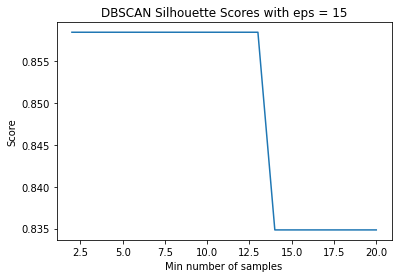

In [23]:
from sklearn.cluster import DBSCAN

n_samples=list(range(2,21))
epss=list(range(2,16))

for e in epss:
    scores = []
    for n in tqdm(n_samples):
            clustering = DBSCAN(eps=e, min_samples=n)
            clustering.fit_predict(sample)
            score = silhouette_score(sample, clustering.labels_, metric='euclidean')
            scores.append(score)
    plt.title(f'DBSCAN Silhouette Scores with eps = {e}')
    plt.xlabel("Min number of samples")
    plt.ylabel("Score")
    plt.plot(n_samples, scores)
    plt.show()

In [24]:
km = KMeans(n_clusters=2)
km.fit_predict(X_transformed)
km_labels = km.labels_
km_labels

array([0, 0, 0, ..., 0, 1, 0], dtype=int32)

In [ ]:
from sklearn.cluster import DBSCAN

cls = DBSCAN(eps=13, min_samples=2)
cls.fit_predict(X_transformed)
DB_labels = cls.labels_
DB_labels

In [ ]:
names = df['encounter_id']
out = pd.DataFrame({'encounter_id': names, 'kmean_label': km_labels, 'dbscan_label': DB_labels})
out.to_csv('/content/drive/MyDrive/Homework_Files/diabetic_data_out.csv')